In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.densenet import DenseNet121, preprocess_input
from PIL import Image, ImageChops, ImageEnhance
import os

np.random.seed(2)

def convert_to_ela_image(path, quality=95):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality=quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 98).resize((128, 128))).flatten() / 255.0

def load_and_split_images(directory, test_ratio=0.2):
    X = []
    Y = []
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith(('jpg', 'bmp', 'tif')):
                full_path = os.path.join(dirname, filename)
                X.append(prepare_image(full_path))
                if 'Au' in dirname:
                    Y.append(0)  # Authentic
                elif 'Tp' in dirname:
                    Y.append(1)  # Tampered

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_ratio, random_state=42)
    return np.array(X_train), np.array(X_test), to_categorical(Y_train, 2), to_categorical(Y_test, 2)

X_train_au, X_test_au, Y_train_au, Y_test_au = load_and_split_images('D:/IF/CASIA2U/Au', test_ratio=0.2)
X_train_tp, X_test_tp, Y_train_tp, Y_test_tp = load_and_split_images('D:/IF/CASIA2U/Tp', test_ratio=0.2)

X_train = np.concatenate((X_train_au, X_train_tp), axis=0)
X_test = np.concatenate((X_test_au, X_test_tp), axis=0)
Y_train = np.concatenate((Y_train_au, Y_train_tp), axis=0)
Y_test = np.concatenate((Y_test_au, Y_test_tp), axis=0)

train_indices = np.random.permutation(len(X_train))
test_indices = np.random.permutation(len(X_test))
X_train = X_train[train_indices].reshape(-1, 128, 128, 3)
Y_train = Y_train[train_indices]
X_test = X_test[test_indices].reshape(-1, 128, 128, 3)
Y_test = Y_test[test_indices]

print("Train set size:", len(X_train))
print("Test set size:", len(X_test))



Train set size: 10090
Test set size: 2524


In [3]:
def build_densenet_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model



In [4]:
# Build the model
model = build_densenet_model()

# Print the model summary
model.summary()

# Set training parameters
epochs = 10
batch_size = 32
init_lr = 1e-5  # Reduced initial learning rate

# Compile the model
optimizer = Adam(learning_rate=init_lr, decay=init_lr/epochs)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("model_best_densenet121.keras", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=300, verbose=1, mode='auto')

# Train the model
hist = model.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, Y_test),
    callbacks=[checkpoint, early_stopping]
)

# Save the final model
model.save('model_densenet_finall21q.keras')


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

c:\Users\SHARON\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6483 - loss: 0.7527
Epoch 1: val_accuracy improved from -inf to 0.70048, saving model to model_best_densenet121.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 908s 3s/step - accuracy: 0.6486 - loss: 0.7522 - val_accuracy: 0.7005 - val_loss: 0.6052
Epoch 2/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8697 - loss: 0.3506
Epoch 2: val_accuracy improved from 0.70048 to 0.89223, saving model to model_best_densenet121.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 792s 3s/step - accuracy: 0.8697 - loss: 0.3505 - val_accuracy: 0.8922 - val_loss: 0.2633
Epoch 3/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8892 - loss: 0.2828
Epoch 3: val_accuracy improved from 0.89223 to 0.91165, saving model to model_best_densenet121.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 743s 2s/step - accuracy: 0.8892 - loss: 0.2827 - val_accuracy: 0.9116 - val_loss: 0.2154
Epoch 4/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9123 - loss: 0.2195
Epoch 

79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 455ms/step
Precision: 0.9028
Recall (TPR): 0.9239
F1 Score: 0.9132
Error Rate: 0.0713
True Negative Rate (TNR): 0.9320
False Positive Rate (FPR): 0.0680
Overall Accuracy: 0.9287


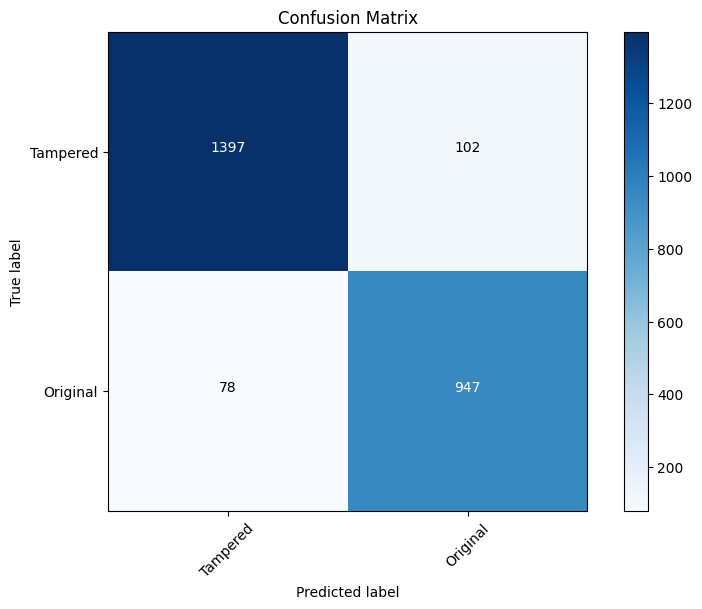

In [5]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import itertools
import matplotlib.pyplot as plt

# Retrieve predictions
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_true_classes, Y_pred_classes)

# Extract confusion matrix components
TN, FP, FN, TP = cm.ravel()

# Calculate metrics
precision = precision_score(Y_true_classes, Y_pred_classes)
recall = recall_score(Y_true_classes, Y_pred_classes)
f1 = f1_score(Y_true_classes, Y_pred_classes)
error_rate = (FP + FN) / (TP + FP + TN + FN)
tpr = recall  # True Positive Rate is the same as recall
tnr = TN / (TN + FP)
fpr = FP / (FP + TN)
accuracy = accuracy_score(Y_true_classes, Y_pred_classes)

print(f"Precision: {precision:.4f}")
print(f"Recall (TPR): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Error Rate: {error_rate:.4f}")
print(f"True Negative Rate (TNR): {tnr:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['Tampered', 'Original']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
thresh = cm.max() / 2.

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


79/79 ━━━━━━━━━━━━━━━━━━━━ 31s 392ms/step
Precision: 0.90
Recall (TPR): 0.92
F1 Score: 0.91
Error Rate: 0.07
True Negative Rate (TNR): 0.93
False Positive Rate (FPR): 0.07
Overall Accuracy: 0.93


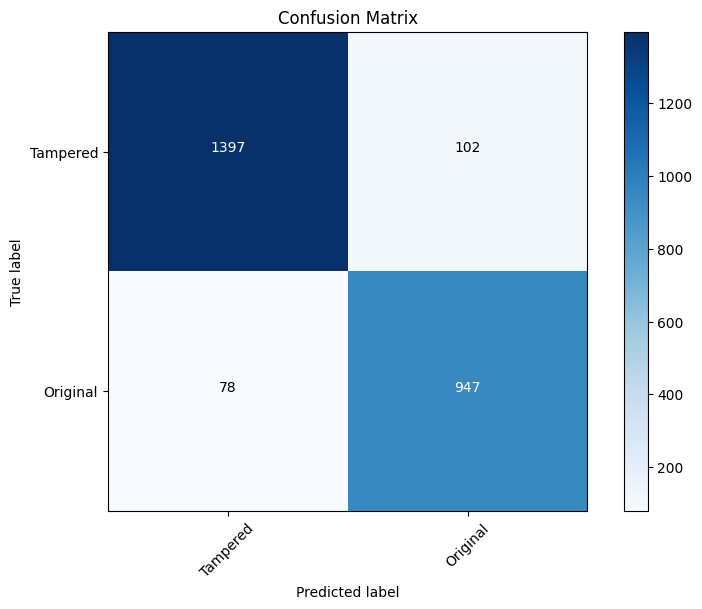

In [6]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import itertools
import matplotlib.pyplot as plt

# Retrieve predictions
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_true_classes, Y_pred_classes)

# Extract confusion matrix components
TN, FP, FN, TP = cm.ravel()

# Calculate metrics
precision = precision_score(Y_true_classes, Y_pred_classes)
recall = recall_score(Y_true_classes, Y_pred_classes)
f1 = f1_score(Y_true_classes, Y_pred_classes)
error_rate = (FP + FN) / (TP + FP + TN + FN)
tpr = recall  # True Positive Rate is the same as recall
tnr = TN / (TN + FP)
fpr = FP / (FP + TN)
accuracy = accuracy_score(Y_true_classes, Y_pred_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall (TPR): {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Error Rate: {error_rate:.2f}")
print(f"True Negative Rate (TNR): {tnr:.2f}")
print(f"False Positive Rate (FPR): {fpr:.2f}")
print(f"Overall Accuracy: {accuracy:.2f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['Tampered', 'Original']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
thresh = cm.max() / 2.

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


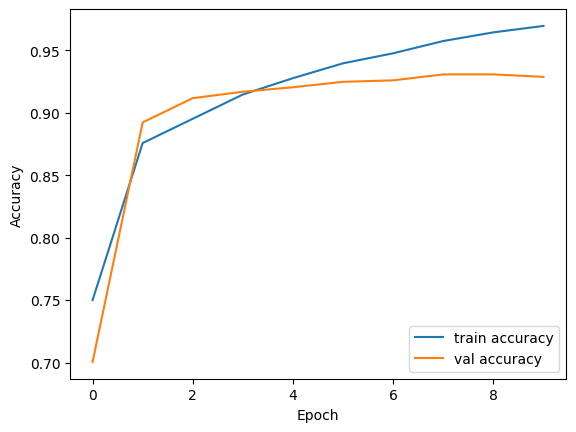

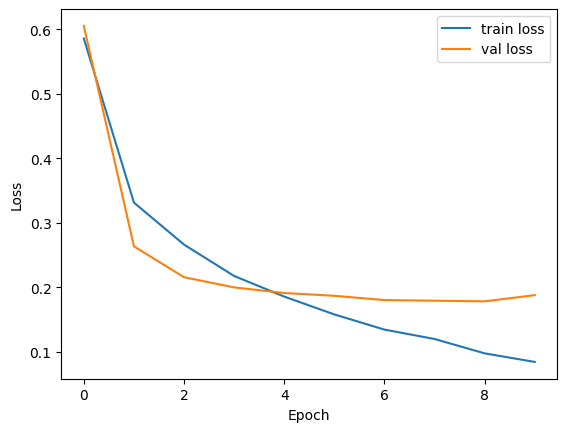

In [7]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()
